In [55]:
import networkx as nx
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axes3d import Axes3D
warnings.filterwarnings('ignore')
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 5)
pylab.rcParams.update({'axes.titlesize':'30'})

Populating the interactive namespace from numpy and matplotlib


## Modelling the Impact of Social Influence on Individual's’ Vaccination Decision Making
### Zachary Newman 21149116
* Human behaviour during a disease epidemic can have are large influence on disease spread and impact.
* Anti vaccination behaviour is of concern
	* vaccination is important to a populations coverage from disease infections.
	* un-vaccinated members can promote disease spread, increasing morbility and mortality of an epidemic

* Thus intertest in understanding the implifications of anti vaxx ideology in a population during an epidemic.
* One way is to model the social and decision making dynamics of a population on vaccination and their adverse effects.

Test attempts to:
* Model the individual decisions process on vaccination
* Model social inluences/pressures on this decision
* Model the social structure (network) between individuals
* Access the impact through Vaccine coverage
* Access the imapct through SIR

## Overview
* Social network is modeled as graph
* Decisions modeled off game theroy
	* including Social impact effects
* impact measured through coverage and SIR

![alt text](fig1.png "Hello")

In [56]:
'''Constants'''
INFECTION_RATE = float(0.8)
SOCIAL_INFLUENCE_FACTOR = float(0.5)
CLOSENESS_FACTOR = float(0.6)
PERCIEVED_INFECTION_RATE = INFECTION_RATE
RECOVERY_RATE = float(0.312)
N = 788
COST_RATIO = float(0.1)
PROB_OF_ANTI_VAC = 0.3
RESPONSIVENESS = 5
I_START = math.floor(max(N * 0.01, 1))

## Choosing the right graph.
Social networks present three main properties
1. Clusters of node associations
2. Degrees of seperation between distant nodes by small intermediate chains
3. Skewed distrubution of degrees in network nodes

Three graphs commonly used are;
* Watts-Strogatz Graph
* Scale Free Graph
* Barabasi Albert Graph

## Setup of graph
Each node represents an individual with the attributes;
* decision, 1 = pro vaxx -1 = anti vaxx
* social influence factor p in (0,1), decides how infuenced by social pressure
    * binomial distrubuted, SOCIAL_INFLUENCE_FACTOR decides the skew

Edges have single weight value representing influence of relationship
* binomially distributed, skew set by CLOSENESS_FACTOR


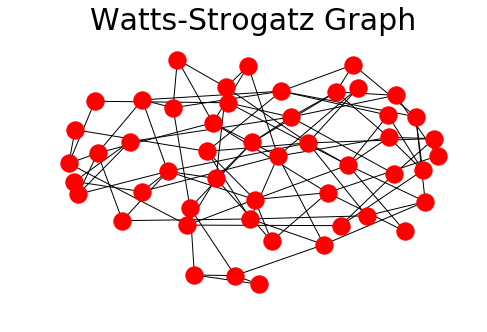

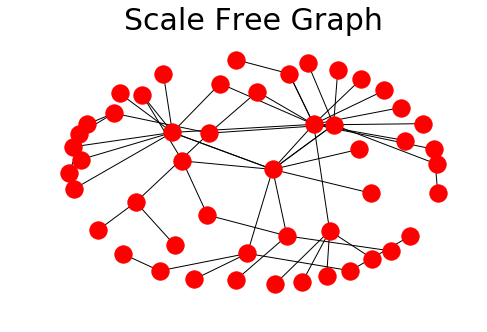

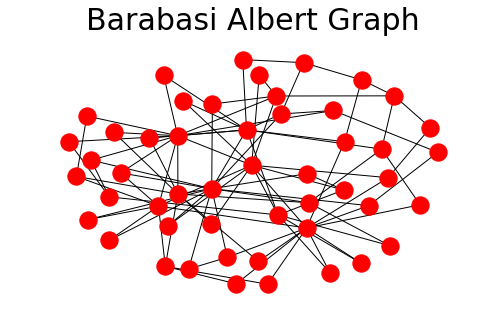

In [57]:
labels = ['Watts-Strogatz Graph', 'Scale Free Graph', 'Barabasi Albert Graph']
graphs = []
graphs.append(nx.watts_strogatz_graph(50, 4, 0.5))
graphs.append(nx.scale_free_graph(
    50, alpha=0.4, beta=0.2, gamma=0.4, delta_in=0, delta_out=0).to_undirected())
graphs.append(nx.barabasi_albert_graph(50, 2))
                
def drawAll():
    for i, g in enumerate(graphs):
        plt.figure()
        plt.title(labels[i])
        nx.draw(g)
            
drawAll()
plt.show()

In [58]:
def makeSFGraph():
    multi_g = nx.scale_free_graph(
        N, alpha=0.4, beta=0.2, gamma=0.4, delta_in=0, delta_out=0)

    # covert to normal and add weights
    g = nx.Graph()
    for u, v, data in multi_g.edges_iter(data=True):
        w = float(np.random.binomial(1000, CLOSENESS_FACTOR, 1)) / float(1000)
        if not g.has_edge(u, v):
            g.add_edge(u, v, weight=w)

    # add inital decisions and social influence to nodes
    for i in g.nodes():
        g.node[i]['decision'] = \
            np.random.choice([1, -1], p=[1 - PROB_OF_ANTI_VAC, PROB_OF_ANTI_VAC])
        g.node[i]['social-influence'] = float(np.random.binomial(1000, SOCIAL_INFLUENCE_FACTOR, 1)) / float(1000)
    return g

g = makeSFGraph()

## Modelling Individual decisions
Influenced by two factors
* rational evaluation
* social influence

Rational Evaluation attempts to make a choice based on cost minimisation of;

$$C_i(\tilde{\sigma}_i)=(1+\tilde{\sigma}_i)r+(1-\tilde{\sigma}_i)\hat{\lambda}_i$$

Where percieved risk $\hat{\lambda}$ is given by;

$$\hat{\lambda}_i=\hat{\beta}\frac{N_i^{non}}{N_i^{non}+N_i^{vac}}$$

Thus the individual obeys the following.

$$\tilde{\sigma}_i=\begin{cases}+1,&\text{if}\ r<\hat{\lambda}_i\\-1,&\text{if}\ r>\hat{\lambda}_i\\\text{unchanged},&\text{if}\ r=\hat{\lambda{}}_i\end{cases}$$

In [59]:
'''Gets number of neighbours with decision to vaccinate'''
def getVacNeighbours(g, index):
    n = g.neighbors(index)
    n_vac = []
    for i in n:
        if g.node[i]['decision'] == 1:
            n_vac.append(i)
    return float(len(n_vac))

'''Gets number of neighbours with decision to not vaccinate'''
def getNonVacNeighbours(g, index):
    n = g.neighbors(index)
    n_non = []
    for i in n:
        if g.node[i]['decision'] == -1:
            n_non.append(i)
    return float(len(n_non))

In [60]:
'''calc func for perceived risk of disease infection'''
def calcPerceivedRiskOfInfection(g, index):
    n_vac = getVacNeighbours(g, index)
    n_non = getNonVacNeighbours(g, index)
    g.node[index]['percieved_risk'] = PERCIEVED_INFECTION_RATE * (n_non / (n_non + n_vac))

In [61]:
'''changes individuals choice'''
def updateDecision(g, index):
    l = g.node[index]['percieved_risk']
    d = g.node[index]['decision']
    if COST_RATIO < l and d == -1:
        g.node[index]['decision'] = 1
        return 1
    elif COST_RATIO > l and d == 1:
        g.node[index]['decision'] = -1
        return 1
    return 0

In [62]:
def makeLocalDecisions(g):
    n = g.nodes()
    random.shuffle(n)
    count = None
    while(count != 0):
        count = 0
        for i in n:
            calcPerceivedRiskOfInfection(g, i)
            count += updateDecision(g, i)

## Adding social influence
Social influence is then by finding the weights of relations

$$l_i^{vac}=(N_i^{vac})^1/2\sum_{j\in{N_i^{vac}}}w_{ij}^2$$

$$l_i^{non}=(N_i^{non})^1/2\sum_{j\in{N_i^{non}}}w_{ij}^2$$

Then using the normalized difference;

$$\triangle{l_i} = \frac{l_i^{vac}-l_i^{non}}{l_i^{vac}+l_i^{non}}$$

The social choice is given by;

$$\hat{\sigma_i}=\begin{cases}+1, & \text{at probability}\ P(\triangle{l_i})\\-1, & \text{at probability}\ 1-P(\triangle{l_i})\end{cases}$$

where probability is given by the Fermi function;

$$P(\triangle{l_i}) = \frac{1}{1+exp(-\alpha\triangle{l_i})}$$

Finally the final decision is calculated following;

$$\sigma_i=\begin{cases}\tilde{\sigma_i}, & \text{at probability}\ 1-p\\ \hat{\sigma_i}, & \text{at probability}\ p\end{cases}$$

In [63]:
def addSocialInfluence(g):
    n = g.nodes()
    random.shuffle(n)
    for i in n:
        l_vac = 0
        l_non = 0
        neighbours = g.neighbors(i)
        for j in neighbours:
            if g.node[j]['decision'] == 1:
                l_vac += g[i][j]['weight']
            else:
                l_non += g[i][j]['weight']

        l_diff = (l_vac - l_non)/(l_vac + l_non)
        prob = 1/(1 + math.exp(-RESPONSIVENESS*l_diff))
        sd = np.random.choice([1, -1], p=[prob, 1-prob])
        g.node[i]['decision'] = np.random.choice([g.node[i]['decision'], sd],
            p=[1-g.node[i]['social-influence'], g.node[i]['social-influence']])

## Changes in decisions

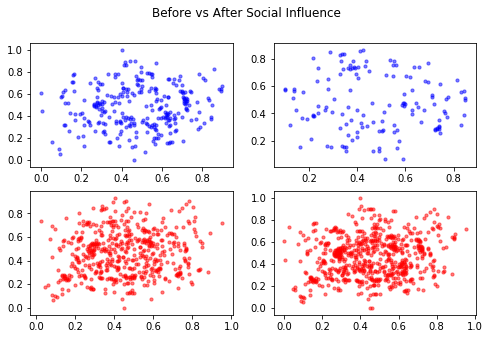

In [64]:
def plotDecDiff(fig, g, j, pos):
    vac, non = [], []
    for i in g.nodes():
        if g.node[i]['decision'] == 1:
            vac.append(i)
        else:
            non.append(i)
    fig.add_subplot(2,2,j)
    nx.draw_networkx_nodes(g, pos,
                           nodelist=vac,
                           node_color='b',
                           alpha=0.5,
                           label="Pro Vaxx",
                           node_size=10)
    fig.add_subplot(2,2,j+2)
    nx.draw_networkx_nodes(g, pos,
                           nodelist=non,
                           node_color='r',
                           alpha=0.5,
                           label="Anti Vaxx",
                           node_size=10)
    
'''Changed constants'''
SOCIAL_INFLUENCE_FACTOR = 0.9
COST_RATIO = 0.8
PROB_OF_ANTI_VAC = 0.3

g = makeSFGraph()
pos = nx.spring_layout(g, weight=None)

fig = plt.figure()
fig.suptitle('Before vs After Social Influence')

makeLocalDecisions(g)
plotDecDiff(fig, g, 1, pos)
addSocialInfluence(g)
plotDecDiff(fig, g, 2, pos)

plt.show()

### Analysis Vaccine Coverage

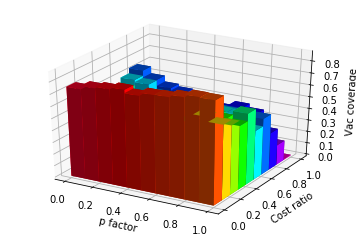

In [68]:
%matplotlib inline
def calcCoverage(g):
    vac = 0
    for n in g.nodes():
        if g.node[n]['decision'] == 1:
            vac += 1

    return float(vac)/N


def plotCoverage(grain):

    x,y,dz = [],[],[]
    assert isinstance(grain, float)

    for i in range(int(grain)):
        for j in range(int(grain)):
            global SOCIAL_INFLUENCE_FACTOR
            SOCIAL_INFLUENCE_FACTOR = j/grain
            global COST_RATIO
            COST_RATIO = i/grain
            g = makeSFGraph()
            x.append(SOCIAL_INFLUENCE_FACTOR)
            y.append(COST_RATIO)
            makeLocalDecisions(g)
            addSocialInfluence(g)
            dz.append(calcCoverage(g))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("p factor")
    ax.set_ylabel("Cost ratio")
    ax.set_zlabel("Vac coverage")
    z = [0] * int(grain**2)
    cm = plt.get_cmap('gist_rainbow')
    cc = [cm(k/(grain**2)) for k in range(int(grain**2))]
    ax.bar3d(x, y, z, 1/grain, 1/grain, dz, color=cc)
    plt.show()

plotCoverage(10.0)

## SIR Analysis
Population is split into three groups
* **(S)** susceptiable to disease
* **(I)** Infected
* **(S)** Recovered from disease

The vaccinated proportion is removed from the population.

With each iteration SIR groups change at the rates;

$$\frac{dS}{dt}=-\lambda S$$

$$\frac{dI}{dt}=\lambda S-\gamma I$$

$$\frac{dR}{dt}=\gamma I$$

$\lambda$ is the risk of infection given by;

$$\lambda=\beta\frac{I}{N}$$

$\beta$ is disease transmission rate and is dependant on the populations coverage.
$\gamma$ is the rate of recovery from disease.

$$\beta = R_0\gamma$$

$R_0$ is the threshold for disease transmission, i.e. the number of people that
need to be infected each iteration for the disease to spread.

$$R_0 = \frac{1}{1-0_{vac}}$$

where $0_{vac}$ is Vaccination coverage given by;

$$0_{vac} = \frac{N_{vac}}{N}$$



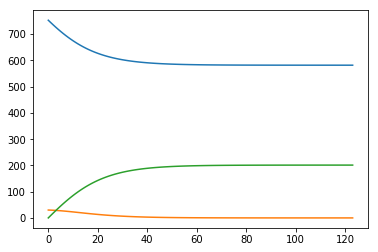

In [76]:
def calcImpact(g):
    s, i, r = [], [], []
    R = 0
    I = I_START
    v_tot = 0.0
    # exclude vaccinated individuals
    for j in g.nodes():
        if g.node[j]['decision'] == 1:
            v_tot += 1
    S = N - v_tot - I
    v_0 = v_tot / N
    r_0 = 1 / (1 - v_0)
    dS, dR, dI = None, None, None
    beta = r_0 * RECOVERY_RATE
    while (dS == None or np.absolute(dS) > 0.001
           or np.absolute(dI) > 0.001 or np.absolute(dR) > 0.001 ):
        s.append(S)
        i.append(I)
        r.append(R)
        lam = beta * I / N
        dS = -lam * S
        dI = lam * S - RECOVERY_RATE * I
        dR = RECOVERY_RATE * I
        S = max(S + dS, 0)
        I = max(I + dI, 0)
        R = max(R + dR, 0)
    return [s, i, r]

def plotSIR(sir_array):
    plt.figure()
    for i in sir_array:
        plt.plot(range(len(i)), i)
        
I_START = 30
INFECTION_RATE = float(10)
SOCIAL_INFLUENCE_FACTOR = float(0.5)
CLOSENESS_FACTOR = float(0.6)
RECOVERY_RATE = float(0.312)
COST_RATIO = float(1)
PROB_OF_ANTI_VAC = 0.9

g3 = makeSFGraph()
makeLocalDecisions(g3)
addSocialInfluence(g3)
sir = calcImpact(g3)
plotSIR(sir)